# MRS second order response
In this notebook we derive a correction for the spectral leak present in MRS band 3A detector images (see MIRI-TN-00002-KUL written by Dr. Bart Vandenbussche).

In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

MIRI-TN-00002-KUL section 2: The MRS spectrometers are designed to cover the respective spectral band wavelength ranges in the first spectral order. A diffraction grating will yield maximum constructive interference for light of wavelength λ in the first order at an exit angle α. At the same exit angle α maximum constructive interference will also be seen for light of wavelength λ/2 (second order), λ/3 (third order), etc... Without a proper pre-selection of the wavelength bandpass entering the spectrometer, (parts of) these higher order spectra will be superimposed on the first order spectrum.  
  
Such an occurence is expected to happen in MRS band 3A due to a spectral leakage from the dichroic transmission in band 1B. This is shown below.

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
import scipy.interpolate as scp_interpolate
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral band of interest
band = "3A"

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
MrsFilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

In [4]:
# Read the measured transmission curves from the csv files
# zeroth colum is wavelength [micrometer]
# first column is room temperature transmission
# second column is 7K transmission
col = 2
filterWave= np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,0]
D1A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1a.csv", delimiter=";")[:,col]/100.
D1B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1b.csv", delimiter=";")[:,col]/100.
D1C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_1c.csv", delimiter=";")[:,col]/100.
D2A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2a.csv", delimiter=";")[:,col]/100.
D2B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2b.csv", delimiter=";")[:,col]/100.
D2C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_2c.csv", delimiter=";")[:,col]/100.
D3A = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3a.csv", delimiter=";")[:,col]/100.
D3B = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3b.csv", delimiter=";")[:,col]/100.
D3C = np.genfromtxt(MrsFilterTransmDir + "fm_dichroics_3c.csv", delimiter=";")[:,col]/100.

<IPython.core.display.Javascript object>


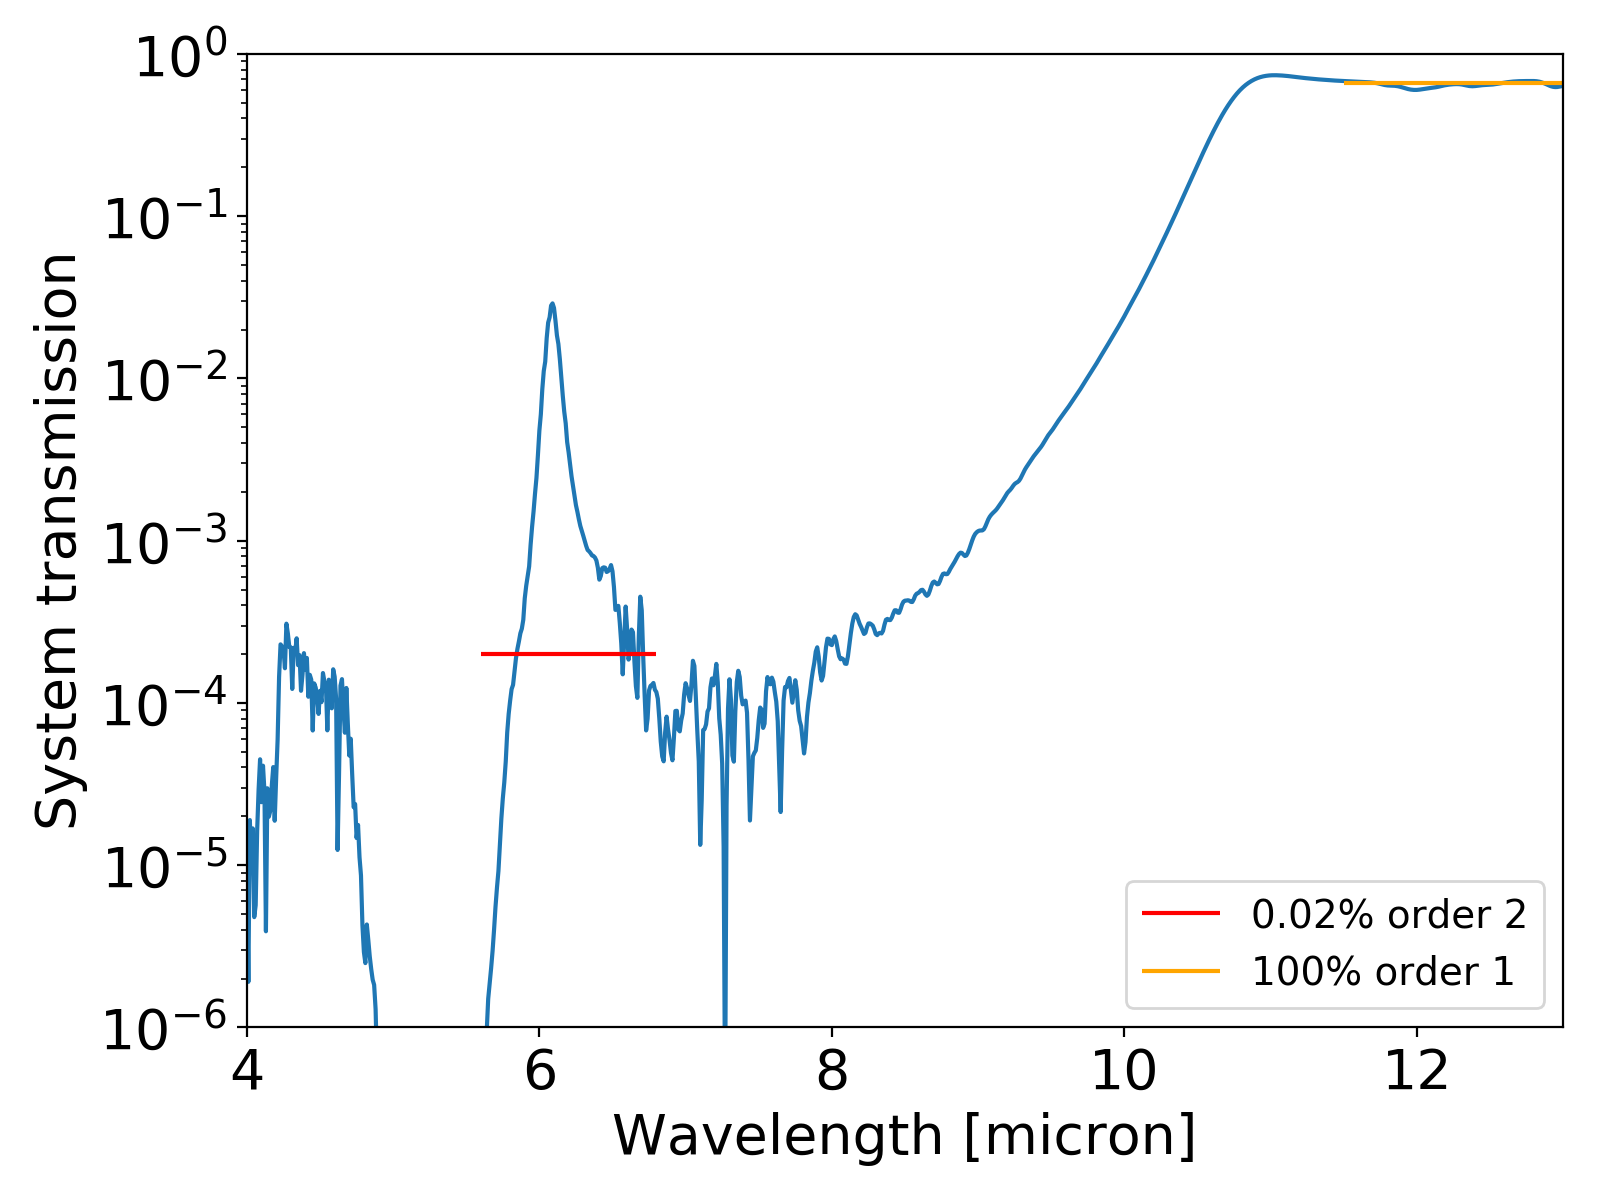

In [5]:
system_transmission = D1A*D2A*(1-D3A)

plt.figure(figsize=(8,6))
plt.semilogy(filterWave,system_transmission,zorder=0)
plt.hlines(0.0002,5.6,6.8,'r',label='0.02% order 2')
plt.hlines(0.66,11.5,13,'orange',label='100% order 1',zorder=1)
plt.xlim(4,13)
plt.ylim(1e-6,1)
plt.xlabel('Wavelength [micron]')
plt.ylabel('System transmission')
plt.legend(loc='lower right')
plt.tight_layout()

### Remarks:
* The spectral leak of 2.8% at 6.1 micron will affect the MRS spectrum at 12.2 microns.  
  
The contribution of the two spectral orders is disentagled as prescribed in MIRI-TN-00002-KUL. The result is shown below.

In [6]:
# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
betaMap   = d2cMaps['betaMap']
sizeMap   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)

# create a "valid" map with all the pixels inside the slices of a particular band
channel = int(band[0])
# slice numbers in the slice map of the distortion CDP for this band
sliceInventory = np.unique(sliceMap)
slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]

validMap = np.zeros(sliceMap.shape)
for ss in slicesInBand:
    s = int(ss - 100*channel)
    # construct a list of y,x coordinates of detector pixels belonging to slices of this band
    pixels = np.where(sliceMap == ss)
    validMap[pixels] = 1

In [7]:
# Populate dictionaries with maps of L_sky
ip_Lsky = {}
for BBTemp in ["400K", "600K", "800K"]:  
    tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
    ip_Lsky[BBTemp] = scp_interpolate.interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"]*1000., kind='cubic')

In [8]:
EXTSOURCE_pixMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    EXTSOURCE_SCI_pixMap,EXTSOURCE_BKG_pixMap = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='img')
    EXTSOURCE_pixMap[BBTemp] = EXTSOURCE_SCI_pixMap-EXTSOURCE_BKG_pixMap

In [9]:
R_n1,R_n2 = {},{}
for relation in ['800K_600K','800K_400K','600K_400K']:
    Resp_order1,Resp_order2 = [np.full((1024,1032),np.nan) for i in range(2)]
    sel = (d2cMaps['lambdaMap'] !=0)
    # solve 2x2 system of radiometric equations
    Teff1,Teff2 = relation.split('_')[0],relation.split('_')[1]
    #-- coefficients
    a1 = EXTSOURCE_pixMap[Teff1][sel]
    a2 = EXTSOURCE_pixMap[Teff2][sel]
    b1 = ip_Lsky[Teff1](d2cMaps['lambdaMap'][sel])*sizeMap[sel]
    b2 = ip_Lsky[Teff2](d2cMaps['lambdaMap'][sel])*sizeMap[sel]
    c1 = ip_Lsky[Teff1](d2cMaps['lambdaMap'][sel]/2.)*sizeMap[sel]
    c2 = ip_Lsky[Teff2](d2cMaps['lambdaMap'][sel]/2.)*sizeMap[sel]
    
    Resp_order1[sel] = (-a1/c1 + a2/c2) / (-b1/c1 + b2/c2)
    Resp_order2[sel] = (-a1/b1 + a2/b2) / (-c1/b1 + c2/b2)
    
    R_n1[relation] = Resp_order1
    R_n2[relation] = Resp_order2

<IPython.core.display.Javascript object>


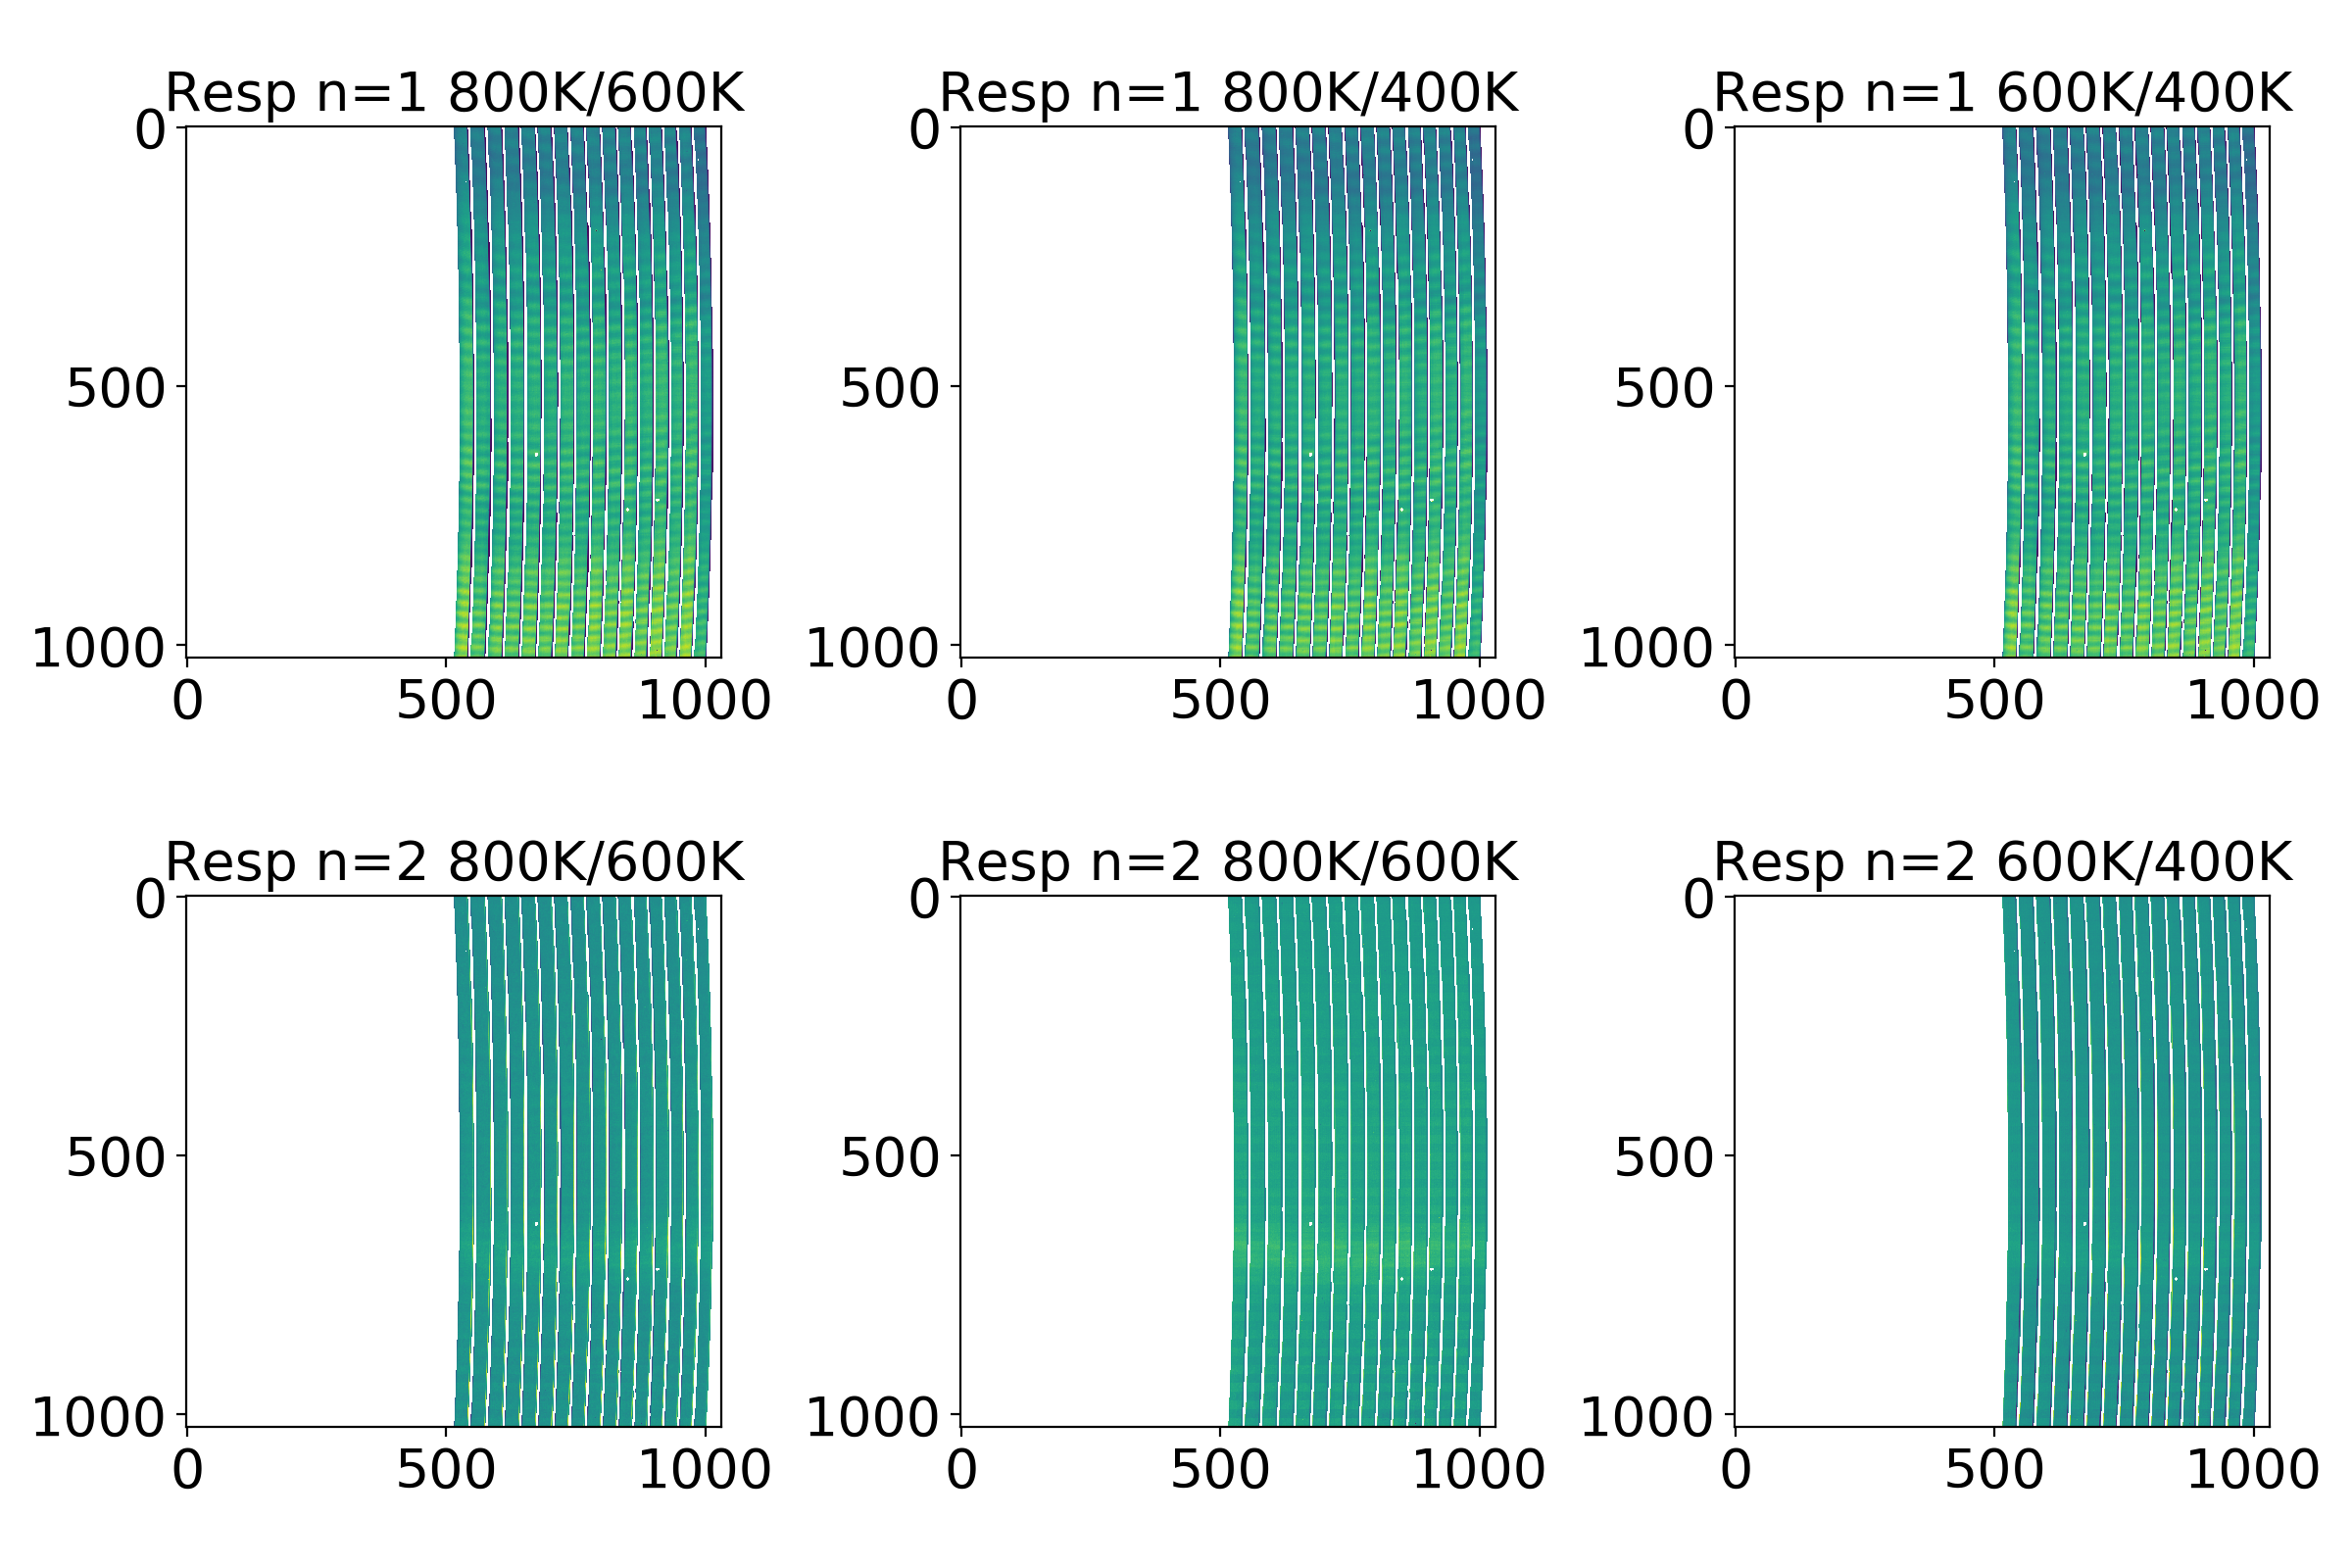

In [22]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
axs[0,0].imshow(R_n1['800K_600K'])
axs[0,0].set_title('Resp n=1 800K/600K')
axs[1,0].imshow(R_n2['800K_600K'])
axs[1,0].set_title('Resp n=2 800K/600K')
axs[0,1].imshow(R_n1['800K_400K'])
axs[0,1].set_title('Resp n=1 800K/400K')
axs[1,1].imshow(R_n2['800K_400K'])
axs[1,1].set_title('Resp n=2 800K/600K')
axs[0,2].imshow(R_n1['600K_400K'])
axs[0,2].set_title('Resp n=1 600K/400K')
axs[1,2].imshow(R_n2['600K_400K'])
axs[1,2].set_title('Resp n=2 600K/400K')
plt.tight_layout()

<IPython.core.display.Javascript object>


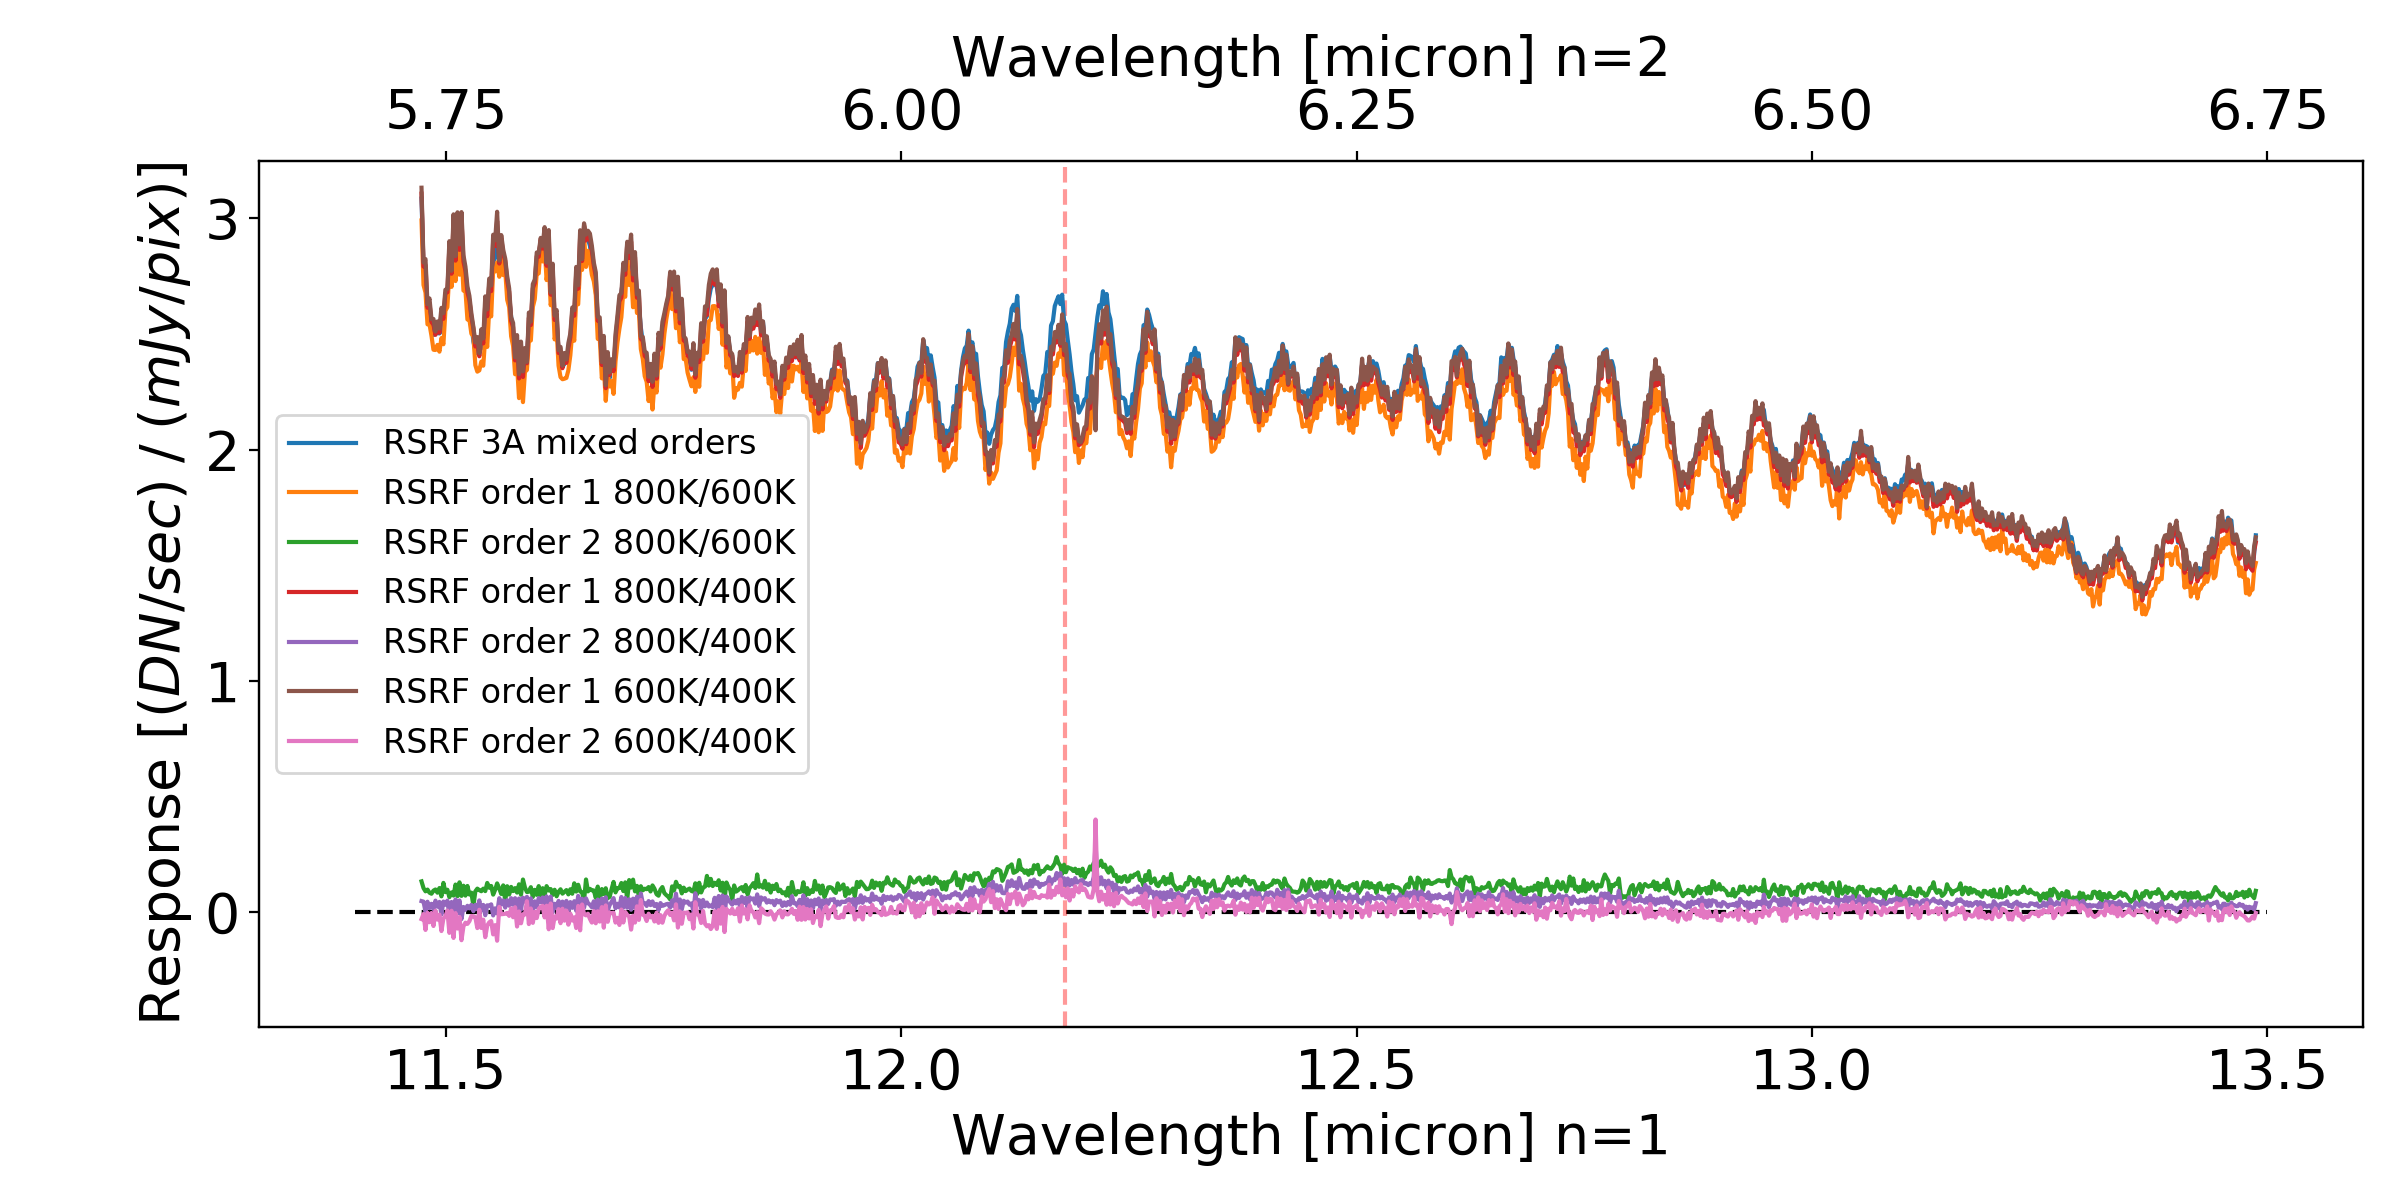

In [10]:
# use RSRF of band 3A as reference
fringe_img,photom_img = funcs.get_cdps(band,cdpDir)[:2]
# plot trace in pixel slice
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)

def tick_function(X):
    # for plotting wavelengths and wavenumbers on the same plot (two x-axes)
    V = X/2.
    return ["%.2f" % z for z in V]

fig = plt.figure(figsize=(12,6))
axs1 = fig.add_subplot(111)
axs2 = axs1.twiny()
axs1.plot(lambdaMap[ypos,xpos],(photom_img*fringe_img)[ypos,xpos],label='RSRF 3A mixed orders')
for relation in ['800K_600K','800K_400K','600K_400K']:
    Teff1,Teff2 = relation.split('_')[0],relation.split('_')[1]
    axs1.plot(d2cMaps['lambdaMap'][ypos,xpos],R_n1[relation][ypos,xpos],label='RSRF order 1 {}/{}'.format(Teff1,Teff2))
    axs1.plot(d2cMaps['lambdaMap'][ypos,xpos],R_n2[relation][ypos,xpos],label='RSRF order 2 {}/{}'.format(Teff1,Teff2))
axs1.hlines(0,11.4,13.5,'k',linestyle='dashed')
axs1.vlines(12.18,-0.5,3.25,'r',alpha=0.4,linestyle='dashed')
axs1.set_ylim(-0.5,3.25)
axs1.set_xlabel('Wavelength [micron] n=1')
axs1.set_ylabel(r'Response $[(DN/sec)\; /\; (mJy/pix)]$')
axs1.legend(loc='center left',fontsize=12)
axs2.set_xlim(axs1.get_xlim())
tickmarks = np.array([11.5,12.,12.5,13.,13.5])
axs2.set_xticks(tickmarks)
axs2.set_xticklabels(tick_function(tickmarks))
axs2.set_xlabel(r'Wavelength [micron] n=2')
plt.tight_layout()

### Remarks:
* The first and second spectral order responses determined from the different pairs of observations agree quite well.